In [1]:
from fink_utils.sso.periods import estimate_synodic_period  # v0.21.0 or more
import requests
import time
import io

import numpy as np
import pandas as pd

import rocks

import matplotlib.pyplot as plt

# import seaborn as sns
# sns.set_context("poster")

In [2]:
cols = [
    "sso_number",
    "sso_name",
    "sso_class",
    "spins.1.period.value",
    "spins.2.period.value",
]

# Read BFT with rocks
bft = rocks.load_bft(columns=cols)

In [32]:
def func_sshg1g2(pha, h, g1, g2, alpha0, delta0, period, a_b, a_c, phi0, t0):
    """Return f(H, G1, G2, R, alpha0, delta0) part of the lightcurve in mag space

    Parameters
    ----------
    pha: array-like [4, N]
        List containing [phase angle in radians, RA in radians, Dec in radians, time (jd)]
    h: float
        Absolute magnitude in mag
    G1: float
        G1 parameter (no unit)
    G2: float
        G2 parameter (no unit)
    alpha0: float
        RA of the spin (radian)
    delta0: float
        Dec of the spin (radian)
    period: float
        Spin period in days
    a_b: float
        Equatorial axes ratio
    a_c: float
        Polar axes ratio
    phi0: float
        Initial rotation phase at reference time t0
    t0: float
        Reference time

    Returns
    -------
    out: array of floats
        H - 2.5 log(f(G1G2)) - 2.5 log(f(spin, shape))
    """
    ph = pha[0]
    ra = pha[1]
    dec = pha[2]
    ep = pha[3]

    # Standard HG1G2 part: h + f(alpha, G1, G2)
    func1 = func_hg1g2(ph, h, g1, g2)

    # Spin part
    cos_aspect = spin_angle(ra, dec, alpha0, delta0)
    sin_aspect = np.sqrt(1 - cos_aspect**2)
    rotation_phase = (2 * np.pi * (ep - t0) / period + phi0) % 2 * np.pi
    # func2 = 1 - (1 - R) * np.abs(geo)
    func2 = (
        a_c * cos_aspect
        + a_c * sin_aspect * np.cos(rotation_phase)
        + sin_aspect * np.sin(rotation_phase)
    )
    func2 = 2.5 * np.log10(func2)

    return func1 + func2

## Period estimation

In [3]:
flavor = "SHG1G2"
ssnamenr = 5209
period_range = (1 / 24, 7)  # 1hour to 7 days

t0 = time.time()
period, chi2red, frequency, power, model, pdf = estimate_synodic_period(
    ssnamenr,
    flavor=flavor,
    Nterms_base=1,
    period_range=period_range,
    return_extra_info=True,
)

print(
    "[{:.2f} seconds] model={}: period={:.2f} hours (chi2red={:.2f}) -- BFT: period={:.2f} hours".format(
        time.time() - t0,
        flavor,
        period,
        chi2red,
        bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0],
    )
)

from erfa import ErfaWarning

 [astropy.utils.exceptions]


[14.09 seconds] model=SHG1G2: period=5.80 hours (chi2red=0.76) -- BFT: period=11.60 hours


In [31]:
pdf.columns

Index(['index', 'Date', 'LAST', 'HA', 'Az', 'H', 'Dobs', 'Dhelio', 'VMag',
       'SDSS:g',
       ...
       'v:classification', 'v:lastdate', 'v:firstdate', 'v:lapse',
       'v:constellation', 'sso_name', 'sso_number', 'i:magpsf_red', 'preds',
       'residuals'],
      dtype='object', length=114)

In [4]:
# dbl peak
period = period * 2

## Residuals

Text(0, 0.5, 'Residual (mag)')

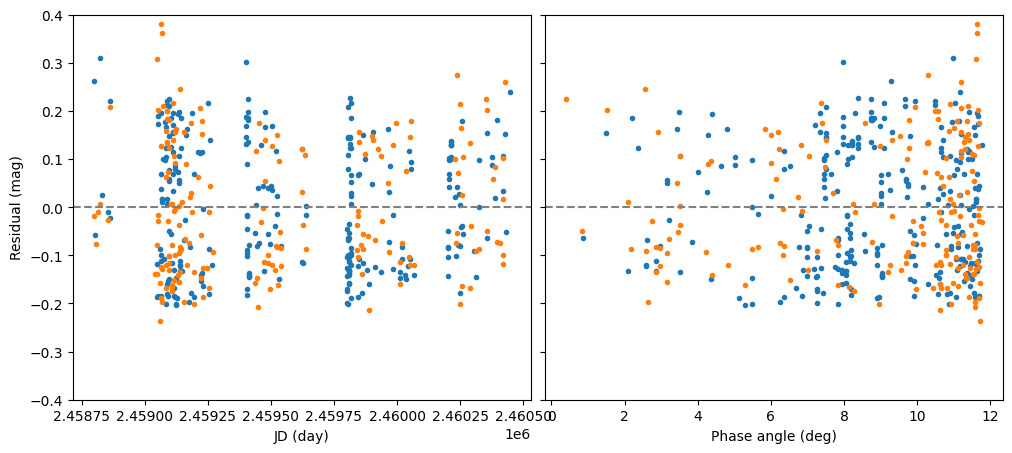

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, gridspec_kw={"wspace": 0.03})

for filtnum in pdf["i:fid"].unique():
    cond = pdf["i:fid"] == filtnum
    ax[0].plot(pdf["i:jd"][cond], pdf["residuals"][cond], ls="", marker=".")
    ax[1].plot(pdf["Phase"][cond], pdf["residuals"][cond], ls="", marker=".")

ax[0].axhline(0, ls="--", color="grey")
ax[1].axhline(0, ls="--", color="grey")

max_res = 0.4
ax[0].set_ylim(-max_res, max_res)
ax[0].set_xlabel("JD (day)")
ax[1].set_xlabel("Phase angle (deg)")
ax[0].set_ylabel("Residual (mag)")

## Folding

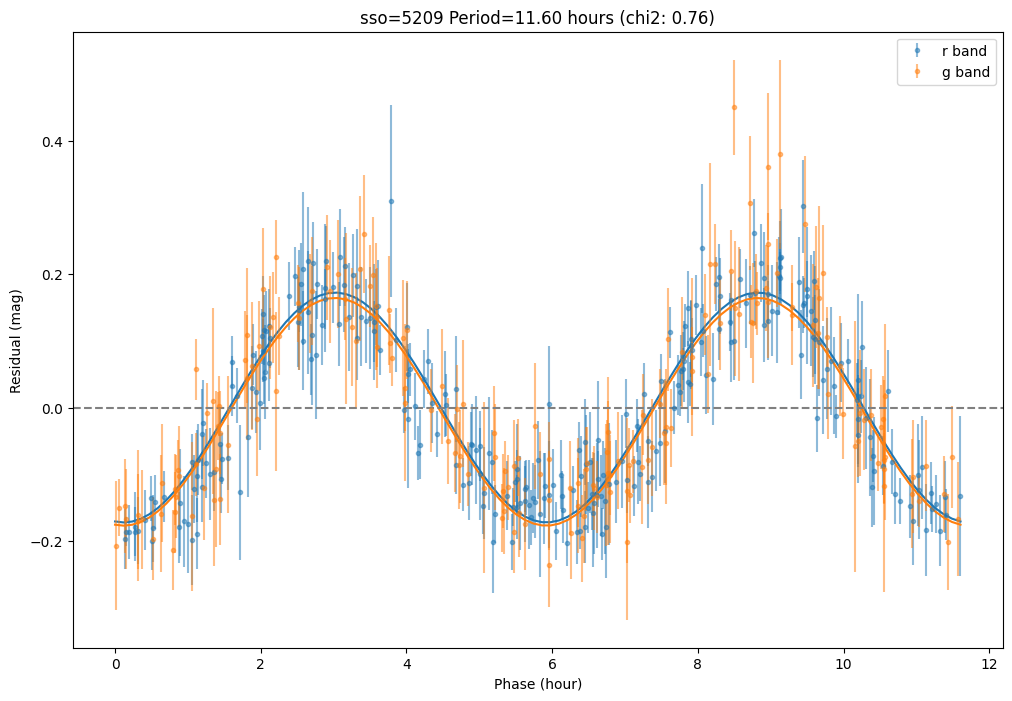

In [22]:
fig = plt.figure(figsize=(12, 8))

tfit = np.linspace(0, period / 24, 100)
magfit = model.model(tfit, 2 / period * 24)
colors = ["C0", "C1"]
dicband = {1: "g", 2: "r"}
for index, (color, filtnum) in enumerate(zip(colors, pdf["i:fid"].unique())):
    cond = pdf["i:fid"] == filtnum
    phase = pdf["i:jd"][cond] % (period / 24)
    plt.errorbar(
        phase * 24,
        pdf["residuals"][cond],
        pdf["i:sigmapsf"][cond],
        ls="",
        marker=".",
        alpha=0.5,
        color=color,
        label="{} band".format(dicband[filtnum]),
    )
    plt.plot(tfit * 24, magfit[index], ls="-", marker="", color=color)
plt.axhline(0, ls="--", color="grey")
# plt.ylim(-0.7, 0.7)
plt.title("sso={} Period={:.2f} hours (chi2: {:.2f})".format(ssnamenr, period, chi2red))
plt.xlabel("Phase (hour)")
plt.ylabel("Residual (mag)")
plt.legend()

In [28]:
amp = magfit.max() - magfit.min()
a_over_b = 10 ** (0.4 * amp)
a_over_b

1.3798947963283803

## Periodogram

In [ ]:
period_bft = bft[bft["sso_number"] == ssnamenr]["spins.1.period.value"].values[0]

fig = plt.figure(figsize=(12, 8))
plt.plot(frequency, power)
plt.axvline(1 / period * 24, ls="--", lw=6, color="C2", label=r"$f_{Fink}$")
plt.axvline(1 / period_bft * 24, ls=":", lw=4, color="C3", label=r"$f_{BFT}$")

offset = -0.5
offset_y = 0.1
plt.text(
    1 / period_bft * 24 * 3 / 2 + offset, 0.7, r"$3/2 \times f_{BFT}$", rotation=90
)
plt.text(
    1 / period_bft * 24 * 2 + offset, 0.7 - offset_y, r"$2 \times f_{BFT}$", rotation=90
)
plt.text(
    1 / period_bft * 24 * 5 / 2 + offset,
    0.7 - offset_y * 2,
    r"$5/2 \times f_{BFT}$",
    rotation=90,
)
plt.text(
    1 / period_bft * 24 * 3 + offset,
    0.7 - offset_y * 3,
    r"$3 \times f_{BFT}$",
    rotation=90,
)
plt.text(
    1 / period_bft * 24 * 7 / 2 + offset,
    0.7 - offset_y * 4,
    r"$7/2 \times f_{BFT}$",
    rotation=90,
)

plt.axvline(1 / period_bft * 24 * 3 / 2, ls="--", lw=2, color="black")
plt.axvline(1 / period_bft * 24 * 2, ls="--", lw=2, color="black")
plt.axvline(1 / period_bft * 24 * 5 / 2, ls="--", lw=2, color="black")
plt.axvline(1 / period_bft * 24 * 3, ls="--", lw=2, color="black")
plt.axvline(1 / period_bft * 24 * 7 / 2, ls="--", lw=2, color="black")

plt.xlim(0, 15)
plt.xlabel(r"Frequency [day$^{-1}$]")
plt.ylabel("Power")
plt.legend()